In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import ipy_utils
import numpy as np
import pandas as pd

In [2]:
GO_counts = ipy_utils.get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')

## Plot ROC Curves

## Results Using 5-Fold CV, using all 8555 Features (Not dimension-reduced), L1 Norm

In [3]:
#GO_terms, roc_aucs_strat = ipy_utils.get_prediction_results('results_all_tissues')
GO_terms, roc_aucs_strat = ipy_utils.get_prediction_results('Results/full_results_all_tissues_loss_l1_neg_0')
GO_gene_counts = ipy_utils.get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')
aucs_prob = ipy_utils.make_roc_curves(GO_terms, GO_gene_counts)
print np.mean(aucs_prob), np.mean(roc_aucs_strat)

OSError: [Errno 2] No such file or directory: 'Results/full_results_all_tissues_loss_l1_neg_0'

## Same plot as above, but using the dimension reduced features (5 features per tissue)

Observation: Using PCA, one can achieve nearly the same AUC score!

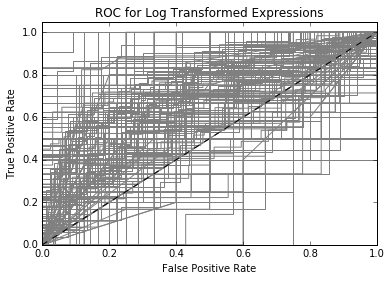

10 236


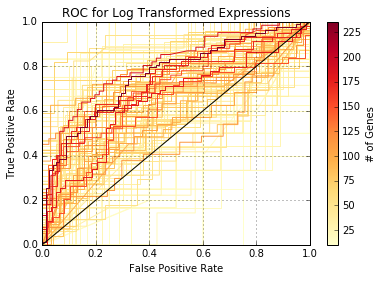

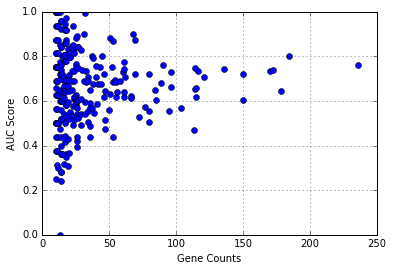

0.661645006671 0.661645006671


In [5]:
GO_terms, roc_aucs_strat = ipy_utils.get_prediction_results('Results/pca_results_all_tissues_loss_l1_neg_0')
GO_gene_counts = ipy_utils.get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')
aucs_prob = ipy_utils.make_roc_curves(GO_terms, GO_gene_counts)
print np.mean(aucs_prob), np.mean(roc_aucs_strat)

## Same plot as above, but only using the median sample! So each example has 53 features.

Observation: Only a slightly lower AUC!

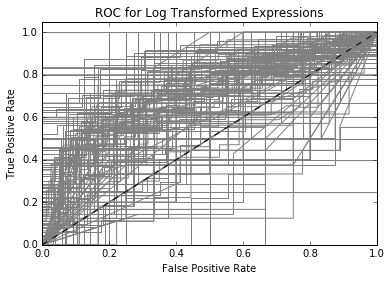

10 236


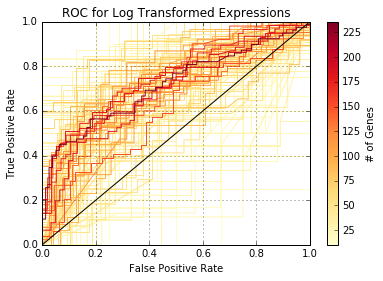

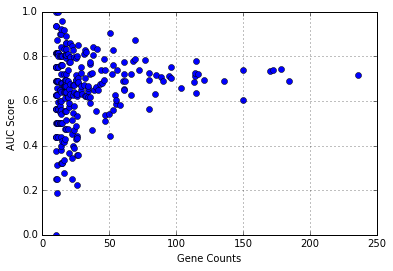

0.649673632976 0.649673632976


In [6]:
GO_terms, roc_aucs_strat = ipy_utils.get_prediction_results('Results/median_results_all_tissues_loss_l1_neg_0')
GO_gene_counts = ipy_utils.get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')
aucs_prob = ipy_utils.make_roc_curves(GO_terms, GO_gene_counts)
print np.mean(aucs_prob), np.mean(roc_aucs_strat)

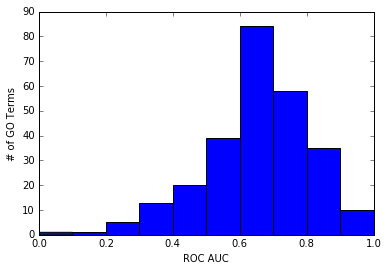

In [7]:
plt.hist(aucs_prob)
plt.xlim([0.0, 1.0])
plt.xlabel('ROC AUC')
plt.ylabel('# of GO Terms')
plt.show()